# Introduction

Walk through the Azure Automatic Machine Learning model training using local machine. 
- Use Dataprep to select columns and infer data type
- Use AutoML and understand prediction performance
- Validate on Out-of-Time sample to benchmark previous model work

### Imports
Import libraries and write settings here.

In [27]:
# Data manipulation
import pandas as pd
import numpy as np
import os
import importlib

# Options for pandas
pd.options.display.max_columns = 2000
pd.options.display.max_rows = 30

# Visualizations
import matplotlib.pyplot as plt

In [28]:
# Import Azure libraries
import azureml.dataprep as dprep

# Dataprep

### Load & Clean Data

Here we are using the Conquest Model dataset which a RandomForest Model was fitted with OOT AUC at 0.7821 

In [29]:
train = dprep.read_csv('data/exp_all_201612_nonsd.csv')

In [30]:
# define the columns needed
useful_columns = ['sales_nonsd','auto_in_the_market_used_0_5_vehicle',
                  'apm_used_0_5_suv_domestic_standard','apm_used_0_5_pickup',
                  'apm_used_0_5_sports_car_domestic','apm_used_0_5_suv_domestic_premium',
                  'apm_used_0_5_luxury_car_domestic','act_int_hunting_enthusiasts',
                  'buyer_non_prestige_makeup_brand_user','apm_used_0_5_mini_van_domestic',
                  'auto_in_the_market_new','consumerview_profitability_score',
                  'buyer_presence_of_automobile','apm_used_6_10_pickup',
                  'apm_used_0_5_small_car_standard','person_1_marital_status']

In [31]:
train2 = (train
    .keep_columns(columns=useful_columns))

### Inferred Data Type

In [32]:
type_infer = train2.builders.set_column_types()
type_infer.learn()
type_infer

Column types conversion candidates:
'apm_used_0_5_small_car_standard': [FieldType.INTEGER],
'apm_used_0_5_luxury_car_domestic': [FieldType.INTEGER],
'apm_used_0_5_suv_domestic_premium': [FieldType.INTEGER],
'apm_used_0_5_pickup': [FieldType.INTEGER],
'auto_in_the_market_used_0_5_vehicle': [FieldType.INTEGER],
'buyer_non_prestige_makeup_brand_user': [FieldType.INTEGER],
'apm_used_0_5_sports_car_domestic': [FieldType.INTEGER],
'apm_used_0_5_suv_domestic_standard': [FieldType.INTEGER],
'apm_used_0_5_mini_van_domestic': [FieldType.INTEGER],
'apm_used_6_10_pickup': [FieldType.INTEGER],
'act_int_hunting_enthusiasts': [FieldType.INTEGER],
'consumerview_profitability_score': [FieldType.INTEGER],
'auto_in_the_market_new': [FieldType.INTEGER],
'buyer_presence_of_automobile': [FieldType.INTEGER],
'sales_nonsd': [FieldType.DECIMAL],
'person_1_marital_status': [FieldType.STRING]

In [33]:
train2 = type_infer.to_dataflow()

In [34]:
train2.head(5)

,person_1_marital_status,apm_used_0_5_small_car_standard,apm_used_0_5_sports_car_domestic,apm_used_0_5_luxury_car_domestic,apm_used_0_5_suv_domestic_standard,apm_used_0_5_suv_domestic_premium,apm_used_0_5_mini_van_domestic,apm_used_0_5_pickup,apm_used_6_10_pickup,auto_in_the_market_new,auto_in_the_market_used_0_5_vehicle,act_int_hunting_enthusiasts,buyer_presence_of_automobile,buyer_non_prestige_makeup_brand_user,consumerview_profitability_score,sales_nonsd
0,1M,4,3,3,4,4,6,1,3,2,2,37,65,84,3,0.00
1,5U,8,6,4,8,8,9,8,8,2,8,44,69,14,3,0.00
2,5M,8,9,9,8,8,9,8,9,9,9,57,79,30,8,0.00
3,1M,8,8,6,8,8,8,7,4,6,6,18,26,64,3,0.00
4,5S,7,9,8,7,7,9,9,9,3,8,82,85,9,6,0.00


# AutoML

In [35]:
# import libraries
import azureml.core
import pandas as pd
from azureml.core.workspace import Workspace
import logging
import os

In [36]:
# configure workspace
ws = Workspace.from_config()
# choose a name for the run history container in the workspace
experiment_name = 'automated-ml-regression'
# project folder
project_folder = './automated-ml-regression'

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
# outputDf.T

In [37]:
dflow_X = train2.drop_columns('sales_nonsd')
dflow_y = train2.keep_columns('sales_nonsd')

In [38]:
x_train = dflow_X.to_pandas_dataframe()
y_train = dflow_y.to_pandas_dataframe()

## Automatically Training

### Define Settings for Autogeneration and Tuning

In [39]:
automl_settings = {
    "iteration_timeout_minutes" : 10,
    "iterations" : 22,
    "primary_metric" : 'AUC_weighted',
    "preprocess" : True,
    "verbosity" : logging.INFO,
    "n_cross_validations": 5,
    "max_cores_per_iteration": 2,
    "max_concurrent_iterations": 1,
}

In [40]:
# any model specifically want to whitelist and focus on for training
ALL = ['LogisticRegression', 'SGD', 'MultinomialNaiveBayes', 'BernoulliNaiveBayes', 'SVM', 'LinearSVM',
       'KNN', 'DecisionTree', 'RandomForest', 'ExtremeRandomTrees', 'LightGBM', 'XGBoostClassifier',
       'GradientBoosting', 'TensorFlowDNN', 'TensorFlowLinearClassifier']
TRY = ['XGBoostClassifier']

In [41]:
from azureml.train.automl import AutoMLConfig

# local compute 
automated_ml_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automated_ml_errors.log',
                             path = project_folder,
                             X = x_train.values,
                             y = y_train.values.flatten(),
#                              auto_blacklist=False,
#                              blacklist_models=[],
#                              enable_early_stopping=True,
#                              enable_tf=True,
#                              whitelist_models=TRY,
#                              enable_onnx_compatible_models=True,
#                              iterations=5,
#                              n_cross_validations=2,
#                              verbosity=100,
                             **automl_settings)

### Train Automatic Models

In [42]:
from azureml.core.experiment import Experiment
experiment=Experiment(ws, experiment_name)
local_run = experiment.submit(automated_ml_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_9565dec3-7e7b-4f85-bcb1-c5732603bb53
Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetFeaturization. Featurizing the dat

# Out of Time Sample Validation

In [43]:
oot = dprep.read_csv('data2/exp_all_201704_nonsd.csv')

In [44]:
oot2 = (oot
    .keep_columns(columns=useful_columns))

In [45]:
type_infer = oot2.builders.set_column_types()
type_infer.learn()
type_infer

Column types conversion candidates:
'apm_used_0_5_small_car_standard': [FieldType.INTEGER],
'apm_used_0_5_suv_domestic_premium': [FieldType.INTEGER],
'apm_used_6_10_pickup': [FieldType.INTEGER],
'act_int_hunting_enthusiasts': [FieldType.INTEGER],
'consumerview_profitability_score': [FieldType.INTEGER],
'apm_used_0_5_sports_car_domestic': [FieldType.INTEGER],
'apm_used_0_5_mini_van_domestic': [FieldType.INTEGER],
'auto_in_the_market_new': [FieldType.INTEGER],
'buyer_presence_of_automobile': [FieldType.INTEGER],
'sales_nonsd': [FieldType.DECIMAL],
'apm_used_0_5_luxury_car_domestic': [FieldType.INTEGER],
'apm_used_0_5_suv_domestic_standard': [FieldType.INTEGER],
'apm_used_0_5_pickup': [FieldType.INTEGER],
'auto_in_the_market_used_0_5_vehicle': [FieldType.INTEGER],
'buyer_non_prestige_makeup_brand_user': [FieldType.INTEGER],
'person_1_marital_status': [FieldType.STRING]

In [46]:
oot2 = type_infer.to_dataflow()

In [47]:
oot2.head(5)

,person_1_marital_status,apm_used_0_5_small_car_standard,apm_used_0_5_sports_car_domestic,apm_used_0_5_luxury_car_domestic,apm_used_0_5_suv_domestic_standard,apm_used_0_5_suv_domestic_premium,apm_used_0_5_mini_van_domestic,apm_used_0_5_pickup,apm_used_6_10_pickup,auto_in_the_market_new,auto_in_the_market_used_0_5_vehicle,act_int_hunting_enthusiasts,buyer_presence_of_automobile,buyer_non_prestige_makeup_brand_user,consumerview_profitability_score,sales_nonsd
0,5U,8,9,6,9,9,9,9,9,2,8,76,99,99,5,0.00
1,5S,9,9,7,9,9,8,9,9,3,8,91,99,23,8,0.00
2,5M,4,1,1,1,1,4,1,1,2,1,18,40,52,2,0.00
3,5M,9,9,8,7,7,9,9,9,1,8,95,90,1,5,0.00
4,1M,5,5,3,3,3,6,7,7,3,4,15,18,27,5,0.00


In [48]:
dflow_X = oot2.drop_columns('sales_nonsd')
dflow_y = oot2.keep_columns('sales_nonsd')

In [49]:
x_valid = dflow_X.to_pandas_dataframe()
y_valid = dflow_y.to_pandas_dataframe().values.flatten()

In [50]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: automated-ml-regression,
Id: AutoML_9565dec3-7e7b-4f85-bcb1-c5732603bb53_20,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_feature_sweeping=None, feature_sweeping_timeout=None,
        is_onnx_compatible=None, logger=None, observer=None, task=None)), ('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('1...
               weights=[0.4, 0.26666666666666666, 0.06666666666666667, 0.2, 0.06666666666666667]))])
Y_transformer(['LabelEncoder', LabelEncoder()])


In [51]:
# generate prediction probability and show results on 10 samples
y_predict = fitted_model.predict_proba(x_valid.values)
y_predict = [i[1] for i in y_predict]
y_predict[:10]

[0.052346208353338475,
 0.02557233395758957,
 0.49936115376951995,
 0.05946531559405773,
 0.2731396874421991,
 0.12080454879736502,
 0.07581706135082152,
 0.3541607057587991,
 0.3655941005143478,
 0.0845862397618308]

(blue)  Best  roc: 0.7735698125764685
(red) random roc: 0.5
1 2.8610689232086113
2 2.764153733858464
3 2.6561940784855085
4 2.623336792067652
5 2.5817543774917775
6 2.529458830873778
7 2.4795615111635882
8 2.443381023808512
9 2.4071413696711708
10 2.38063465121643
11 2.3515676247291286
12 2.3204423113921218
13 2.299075517509534
14 2.2765011144299474
15 2.2520770667109358
16 2.227185601412031
17 2.200544887597454
18 2.177876662481032
19 2.156112282726436
20 2.1332110011404564
21 2.1104396788727153
22 2.0928259070856905
23 2.0766717385017364
24 2.0564105455343498
25 2.0349207757704697
26 2.017696506220745
27 1.997146247646681
28 1.9784780321609055
29 1.9606973939733234
30 1.9445439103058255
31 1.92654677478511
32 1.9085354996758368
33 1.8891559132014395
34 1.8706726744750333
35 1.8539556222058875
36 1.8386274811470895
37 1.8236801396310853
38 1.8067293194101617
39 1.7903504210127734
40 1.7742934665642283
41 1.7589389650203235
42 1.743447850743384
43 1.7271746923343618
44 1.71092584275836

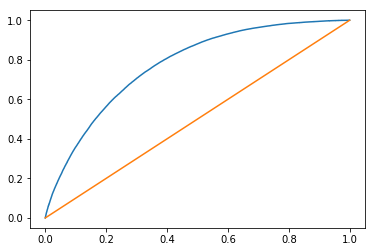

In [52]:
rank_count = 100
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_predict)

#plotting roc
print("(blue) ", 'Best', " roc:", metrics.auc(fpr,tpr))
print("(red) random roc: 0.5")
plt.plot(fpr,tpr,
         [0,1],[0,1])

#Lift
deciles = pd.DataFrame({'y' : y_valid,
                        'yhat' : y_predict})

decile_length = deciles.shape[0]//rank_count
overall_rate = deciles['y'].mean()

decile_event_cum = 0
decile_count_cum = 0
for decile_n in range(rank_count):

    decile_event = deciles.\
        sort_values('yhat', ascending= False).\
        reset_index(drop=True).\
        loc[decile_n*decile_length:(decile_n+1)*decile_length,'y'].\
        values.\
        sum()    

    decile_count = deciles.\
        reset_index(drop=True).\
        loc[decile_n*decile_length:(decile_n+1)*decile_length,'y'].\
        count()

    decile_event_cum += decile_event

    decile_count_cum += decile_count

    print(decile_n + 1, decile_event_cum / decile_count_cum / overall_rate)

## Results

Ran 22 iterations and the best model is VotingEnsemble with OOT AUC = 0.7735 (vs. previous random forest benchmark 0.7821)

# Explain